In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CPU")
else:
  print("GPU")

GPU


In [3]:
batch_size = 20
valid_size = 0.2

transform = T.Compose([T.ToTensor(), T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# obtain training indicies that will be used for validation
num_train = len(train_data)
indicies = list(range(num_train))
np.random.shuffle(indicies)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indicies[split:], indicies[:split]

In [5]:
#define samplers for obtaining training and validation batches

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [6]:
#prepare data loaders (combima dataser and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [7]:
# specify the image classes
classes = ['airplaine', 'automobile', 'bird', 'cat', 'deer', 'dog', 
           'frog', 'horse', 'ship', 'truck']

In [8]:
for images, Labels in train_loader:
  print(images.shape)
  break

torch.Size([20, 3, 32, 32])


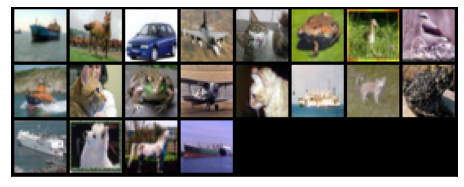

In [9]:
#Visualizing a batch of training data

stats =((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))

def denorm(img_tensors):
    return img_tensors*stats[1][0]+stats[0][0]

def show_images(images,nmax=60):
    fig,ax=plt.subplots(figsize=(8,8))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))
    
def show_batch(dl,nmax=64):
    for images, _ in dl:
        show_images(images,nmax)
        break

show_batch(train_loader)

In [10]:
# Modelling

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()# first 3 lines is mandatory for inheriting properties of model
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.out = nn.Linear(64, 10)
        self.drop_out = nn.Dropout(p=.5)
    def forward(self,X):
        # input image size is [3,32,32]
        X = F.relu(self.conv1(X)) 
        # (32-3+2*1/1+1 -> 32
        # our result will be [16,32,32]
        X = self.pool(X)
        # 32/2 -> 16
        # [16,16,16]
        X = F.relu(self.conv2(X))
        # out_channel is 32
        # (16-3+2*1)/1 + 1 ->16
        # [32,16,16]
        X = self.pool(X)
        # 16/2 -> 8
        # [32,8,8]
        X = F.relu(self.conv3(X))
        # out_channel is 64
        # (8-3+2*1)/1 + 1 ->8
        # [64,8,8]
        X = self.pool(X)
        # 8/2 -> 4
        # [64,4,4]
        X = X.view(-1, 64*4*4)
        # [ 64*4*4] -> one dimension
        X = self.drop_out(X)
        # Regularization and preventing the co-adaptation of neurons as described in the paper
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        out = self.out(X)
        return X

In [12]:
model = NeuralNetwork()
#move tensors to Gpu if CUDA is available
if train_on_gpu:
  model.cuda()

In [13]:
n_epochs = 15  # how many times model will go back and forth
num_classes = 10 # number of labels we should predict
learning_rate = 0.01

In [14]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss() #loss function for defining if we  predicted right or wronge
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # optimisation function for creating gradient decent and learning

In [15]:
#List tp store loss to visualize
train_losslist = []
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
  #keep track of trainng and validation loss
  train_loss = 0.0
  valid_loss = 0.0
  
  # train the model
  model.train()
  for data, target in train_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
      # clear the gradients of all optimized variables
      optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model 
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # backward pass: compute gradient of the loss with respect to model parameters 
      loss.backward()

      # perform a single optimization step (parameter update) 
      optimizer.step()
      # update training loss
      train_loss += loss.item() *data.size(0)
    # validate the model
  model.eval ()
  for data, target in valid_loader:
    data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update average validation loss 
    valid_loss += loss.item() *data.size(0)
# calculate average losses
train_loss = train_loss/len(train_loader.dataset) 
valid_loss = valid_loss/len(valid_loader.dataset) 
train_losslist.append(train_loss)
# print training/validation statistics
print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
    epoch, train_loss, valid_loss))
# save model if validation loss has decreased 
if valid_loss <= valid_loss_min:
  print ('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
      valid_loss_min,
      valid_loss))
  torch.save(model.state_dict(), "model_cifar.pt")
  valid_loss_min=valid_loss

Epoch: 15 	Training Loss: 0.686236 	Validation Loss: 0.164020
Validation loss decreased (inf --> 0.164020). Saving model ...


In [16]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10)) 
class_total = list(0. for i in range(10))

model .eval ()
# iterate over test data
for data, target in test_loader:
  data, target = data.cuda(), target.cuda()
  # forward pass: compute predicted outputs by passing inputs to the model
  output = model(data)
  # calculate the batch loss
  loss = criterion(output, target)
  # update test loss
  test_loss += loss.item() *data.size (0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  # compare predictions to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor)
  # calculate test accuracy for each object class 
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset) 
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
  if class_total[i] > 0:
    print ('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
         classes[i], 100 * class_correct[i] / class_total[i], 
         np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print ('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2da/%2d)' % (
     100. * np.sum(class_correct) / np.sum(class_total), 
     np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.821435

Test Accuracy of airplaine: 68% (685/1000)
Test Accuracy of automobile: 88% (885/1000)
Test Accuracy of  bird: 52% (525/1000)
Test Accuracy of   cat: 48% (484/1000)
Test Accuracy of  deer: 54% (548/1000)
Test Accuracy of   dog: 72% (725/1000)
Test Accuracy of  frog: 86% (863/1000)
Test Accuracy of horse: 73% (737/1000)
Test Accuracy of  ship: 86% (865/1000)
Test Accuracy of truck: 79% (799/1000)

Test Accuracy (Overall): 71% (7116a/10000)
